In [3]:
import numpy as np
import pandas as pd
import matplotlib as mpl
import matplotlib.pyplot as plt
import seaborn as sns
import os
import statsmodels.tsa.api as tsa
from pmdarima.model_selection import train_test_split
from pmdarima.arima.utils import ndiffs

# Set wide fig size for plots
plt.rcParams['figure.figsize']=(12,3)

In [4]:
def plot_forecast(ts_train, ts_test, forecast_df, n_train_lags=None, 
                  figsize=(10,4), title='Comparing Forecast vs. True Data'):
    ### PLot training data, and forecast (with upper/,lower ci)
    fig, ax = plt.subplots(figsize=figsize)

    # setting the number of train lags to plot if not specified
    if n_train_lags==None:
        n_train_lags = len(ts_train)
            
    # Plotting Training  and test data
    ts_train.iloc[-n_train_lags:].plot(ax=ax, label="train")
    ts_test.plot(label="test", ax=ax)

    # Plot forecast
    forecast_df['mean'].plot(ax=ax, color='green', label="forecast")

    # Add the shaded confidence interval
    ax.fill_between(forecast_df.index, 
                    forecast_df['mean_ci_lower'],
                   forecast_df['mean_ci_upper'],
                   color='green', alpha=0.3,  lw=2)

    # set the title and add legend
    ax.set_title(title)
    ax.legend();
    
    return fig, ax

In [5]:
# Custom function for Ad Fuller Test
def get_adfuller_results(ts, alpha=.05, label='adfuller', **kwargs): #kwargs for adfuller()
    # Saving each output
    (test_stat, pval, nlags, nobs, crit_vals_d, 
    icbest ) = tsa.adfuller(ts, **kwargs)
    # Converting output to a dictionary with the interpretation of p
    adfuller_results = {'Test Statistic': test_stat,
                        "# of Lags Used":nlags, 
                       '# of Observations':nobs,
                        'p-value': round(pval,6),
                        'alpha': alpha,
                       'sig/stationary?': pval < alpha}
    return pd.DataFrame(adfuller_results, index =[label])


In [6]:
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score, mean_absolute_percentage_error

def regression_metrics_ts(ts_true, ts_pred, label="", verbose=True, output_dict=False,):
    # Get metrics
    mae = mean_absolute_error(ts_true, ts_pred)
    mse = mean_squared_error(ts_true, ts_pred)
    rmse = mean_squared_error(ts_true, ts_pred, squared=False)
    r_squared = r2_score(ts_true, ts_pred)
    mae_perc = mean_absolute_percentage_error(ts_true, ts_pred) * 100

    if verbose == True:
        # Print Result with label
        header = "---" * 20
        print(header, f"Regression Metrics: {label}", header, sep="\n")
        print(f"- MAE = {mae:,.3f}")
        print(f"- MSE = {mse:,.3f}")
        print(f"- RMSE = {rmse:,.3f}")
        print(f"- R^2 = {r_squared:,.3f}")
        print(f"- MAPE = {mae_perc:,.2f}%")

    if output_dict == True:
        metrics = {
            "Label": label,
            "MAE": mae,
            "MSE": mse,
            "RMSE": rmse,
            "R^2": r_squared,
            "MAPE(%)": mae_perc,
        }
        return metrics


In [7]:
def plot_acf_pacf(ts, nlags=40, figsize=(10, 5), 
                  annotate_sig=False, alpha=.05,
                 acf_kws={}, pacf_kws={},  
                  annotate_seas=False, m = None,
                 seas_color='black'):
    
    fig, axes = plt.subplots(nrows=2, figsize=figsize)

    
    # Sig lags line style
    sig_vline_kwargs = dict( ls=':', lw=1, zorder=0, color='red')

    # ACF
    tsa.graphics.plot_acf(ts, ax=axes[0], lags=nlags, **acf_kws)
    
    ## Annotating sig acf lags
    if annotate_sig == True:
        sig_acf_lags = get_sig_lags(ts,nlags=nlags,alpha=alpha, type='ACF')
        for lag in sig_acf_lags:
            axes[0].axvline(lag,label='sig', **sig_vline_kwargs )

    # PACF
    tsa.graphics.plot_pacf(ts,ax=axes[1], lags=nlags, **pacf_kws)
    
    ## Annotating sig pacf lags
    if annotate_sig == True:
        ## ANNOTATING SIG LAGS
        sig_pacf_lags = get_sig_lags(ts,nlags=nlags,alpha=alpha, type='PACF')
        for lag in sig_pacf_lags:
            axes[1].axvline(lag, label='sig', **sig_vline_kwargs)



    
    ### ANNOTATE SEASONS
    if annotate_seas == True:
        # Ensure m was defined
        if m is None:
            raise Exception("Must define value of m if annotate_seas=True.")

        ## Calculate number of complete seasons to annotate
        n_seasons = nlags//m 

        # Seasonal Lines style
        seas_vline_kwargs = dict( ls='--',lw=1, alpha=.7, color=seas_color, zorder=-1)
        
        ## for each season, add a line
        for i in range(1, n_seasons+1):
            axes[0].axvline(m*i, **seas_vline_kwargs, label="season")
            axes[1].axvline(m*i, **seas_vline_kwargs, label="season")

    fig.tight_layout()
    
    return fig

In [8]:
# Load in data
ts = pd.read_csv("WMT.csv", 
                  parse_dates=['Date'], index_col='Date')
ts.head()



,Adj Close
Date,
2000-01-03,44.915394
2000-01-04,43.234756
2000-01-05,42.352402
2000-01-06,42.814564
2000-01-07,46.049828


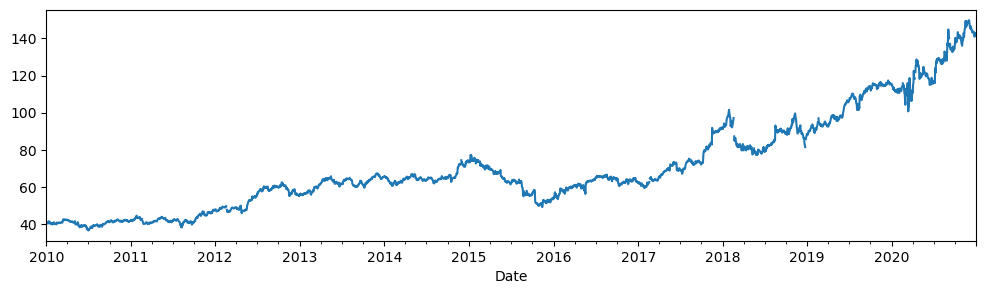

In [15]:
# Filter for 2010-2020 and only the adj close value

ts = ts.loc['2010':'2020', 'Adj Close']
ts.plot();

In [16]:
# Preview the index
ts.index


DatetimeIndex(['2010-01-01', '2010-01-04', '2010-01-05', '2010-01-06',
               '2010-01-07', '2010-01-08', '2010-01-11', '2010-01-12',
               '2010-01-13', '2010-01-14',
               ...
               '2020-12-18', '2020-12-21', '2020-12-22', '2020-12-23',
               '2020-12-24', '2020-12-25', '2020-12-28', '2020-12-29',
               '2020-12-30', '2020-12-31'],
              dtype='datetime64[ns]', name='Date', length=2870, freq=None)

In [17]:
# Resample for business day with 'B'
ts = ts.resample('B').asfreq()
ts



Date
2010-01-01           NaN
2010-01-04     40.963638
2010-01-05     40.555729
2010-01-06     40.465084
2010-01-07     40.487759
                 ...    
2020-12-25           NaN
2020-12-28    142.946777
2020-12-29    142.041183
2020-12-30    141.923065
2020-12-31    141.893524
Freq: B, Name: Adj Close, Length: 2870, dtype: float64

In [25]:
# Check for nulls
ts.isna().sum()



1

In [26]:
# Inspect null values
null = ts.isna()
ts[null].head(20)



Date
2010-01-01   NaN
Freq: B, Name: Adj Close, dtype: float64

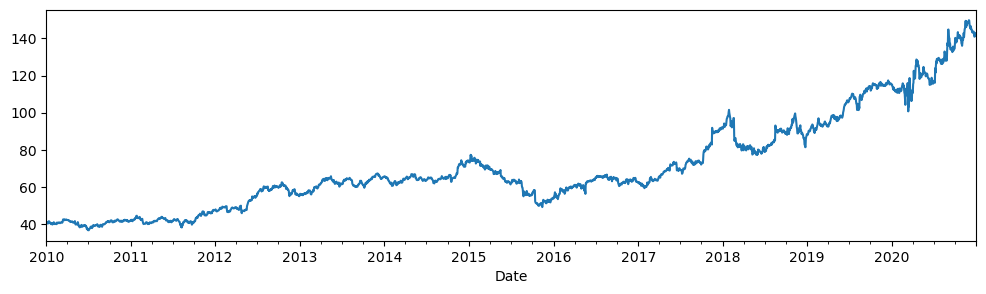

In [27]:
# Fill missing values with previous value
ts = ts.fillna(method='ffill')
ts.plot();


In [29]:
# Inspect null values
null = ts.isna()
ts[null].head(20)

Date
2010-01-01   NaN
Freq: B, Name: Adj Close, dtype: float64

In [34]:
ts['2010-01-01'] = ts['2010-01-04']

In [35]:
ts

Date
2010-01-01     40.963638
2010-01-04     40.963638
2010-01-05     40.555729
2010-01-06     40.465084
2010-01-07     40.487759
                 ...    
2020-12-25    141.253738
2020-12-28    142.946777
2020-12-29    142.041183
2020-12-30    141.923065
2020-12-31    141.893524
Freq: B, Name: Adj Close, Length: 2870, dtype: float64

In [36]:
# Testing the raw data for stationarity
get_adfuller_results(ts)


,Test Statistic,# of Lags Used,# of Observations,p-value,alpha,sig/stationary?
adfuller,1.457375,23,2846,0.99736,0.05,False


In [37]:
# use ndiffs to determine differencing
d = ndiffs(ts)
print(f'd is {d}')


d is 1


,Test Statistic,# of Lags Used,# of Observations,p-value,alpha,sig/stationary?
adfuller,-12.211384,22,2846,0.0,0.05,True


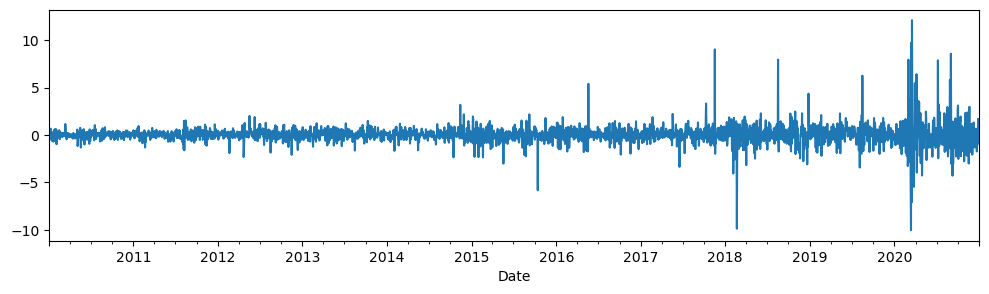

In [38]:
# Differencing the data once
ts_diff = ts.diff().dropna()
ts_diff.plot()
# Checking for stationarity
get_adfuller_results(ts_diff)


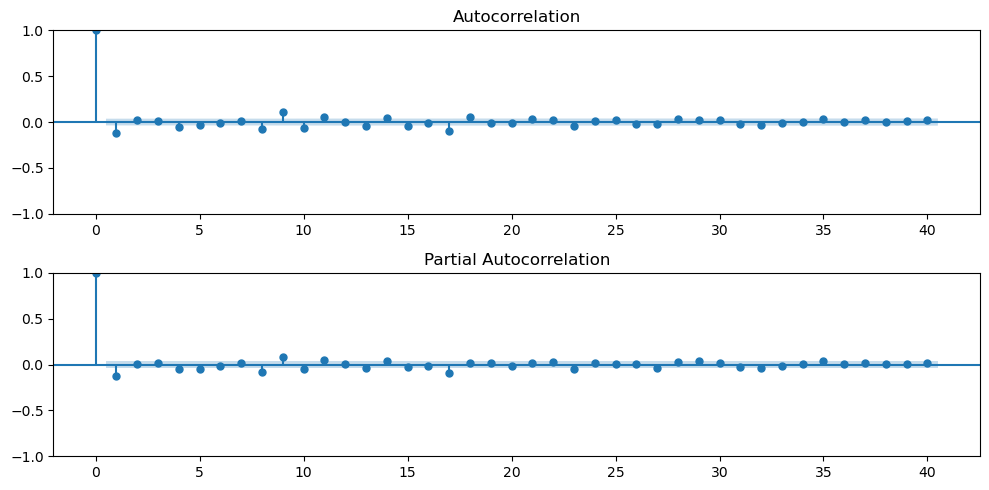

In [40]:
plot_acf_pacf(ts_diff);


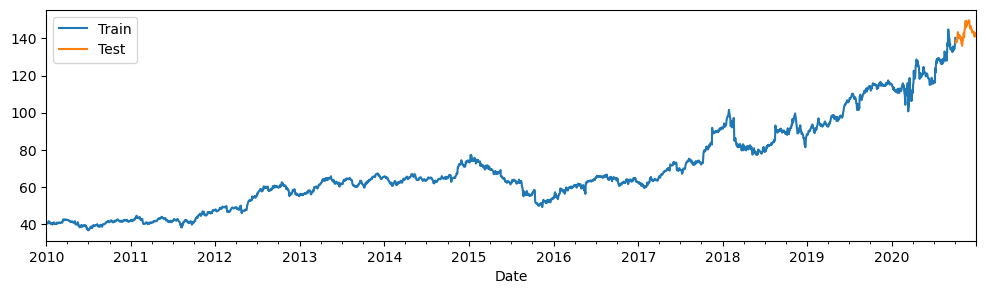

In [41]:
# Calculating number of test lags
n_test_lags = 5*13

# Modeling to predict 6 months into the future
train, test = train_test_split(ts, test_size=n_test_lags)
ax = train.plot(label='Train')
test.plot(ax=ax, label='Test')
ax.legend();


In [42]:
# Build the model 
p = 0  # AR component 

d = 1  # Number of differencing required to make stationary

q =  1 # MA component 

# Define and fit the model
arima_model = tsa.ARIMA(train, order=(p,d,q)).fit()


------------------------------------------------------------
Regression Metrics: 
------------------------------------------------------------
- MAE = 3.813
- MSE = 22.964
- RMSE = 4.792
- R^2 = -0.786
- MAPE = 2.62%


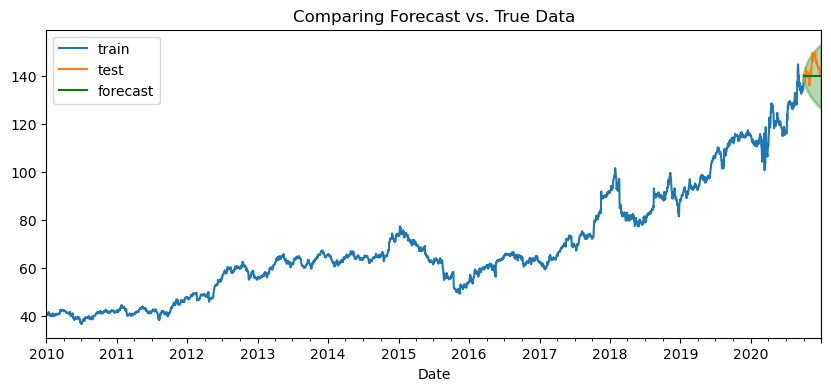

In [43]:
# Obtain summary of forecast as dataframe
forecast_df = arima_model.get_forecast(len(test)).summary_frame()

# Plot the forecast with true values
plot_forecast(train, test, forecast_df)

# Obtain metrics
regression_metrics_ts(test, forecast_df['mean'])


In [44]:
# Obtain summary of model
arima_model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:              Adj Close   No. Observations:                 2805
Model:                 ARIMA(0, 1, 1)   Log Likelihood               -3889.130
Date:                Thu, 02 Nov 2023   AIC                           7782.259
Time:                        00:43:37   BIC                           7794.137
Sample:                    01-01-2010   HQIC                          7786.547
                         - 10-01-2020                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ma.L1         -0.1161      0.006    -19.197      0.000      -0.128      -0.104
sigma2         0.9381      0.006    148.421      0.000       0.926       0.950
===================================================================================
Ljung-Box (L1) (Q):                   0.05   Jarque-Bera (JB):            116415.03
Prob(Q):                              0.83   Prob(JB):                         0.00
Heteroskedasticity (H):              10.49   Skew:                             0.99
Prob(H) (two-sided):                  0.00   Kurtosis:                        34.50
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

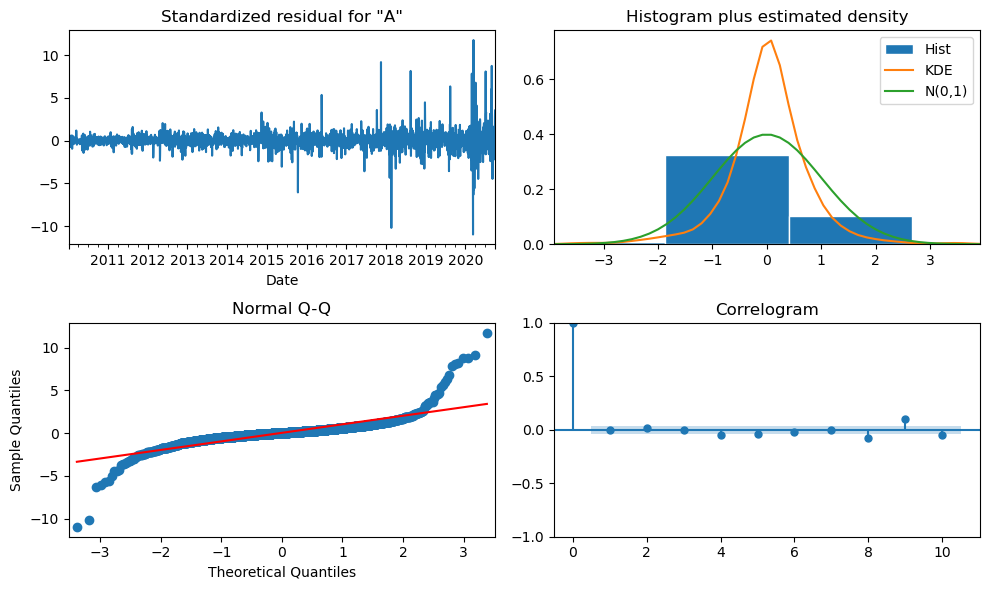

In [45]:
# Obtain diagnostic plots
fig = arima_model.plot_diagnostics()
fig.set_size_inches(10,6)
fig.tight_layout()


In [55]:
import itertools

# Define the value or range of values for p, d, q
p_values = range(0, 4)  
d_values = range (0,3)         
q_values = range(0, 4)  

# Create combinations of pdq to test
pdq_to_try = list(itertools.product(p_values, d_values, q_values))
                                            
pdq_to_try


[(0, 0, 0),
 (0, 0, 1),
 (0, 0, 2),
 (0, 0, 3),
 (0, 1, 0),
 (0, 1, 1),
 (0, 1, 2),
 (0, 1, 3),
 (0, 2, 0),
 (0, 2, 1),
 (0, 2, 2),
 (0, 2, 3),
 (1, 0, 0),
 (1, 0, 1),
 (1, 0, 2),
 (1, 0, 3),
 (1, 1, 0),
 (1, 1, 1),
 (1, 1, 2),
 (1, 1, 3),
 (1, 2, 0),
 (1, 2, 1),
 (1, 2, 2),
 (1, 2, 3),
 (2, 0, 0),
 (2, 0, 1),
 (2, 0, 2),
 (2, 0, 3),
 (2, 1, 0),
 (2, 1, 1),
 (2, 1, 2),
 (2, 1, 3),
 (2, 2, 0),
 (2, 2, 1),
 (2, 2, 2),
 (2, 2, 3),
 (3, 0, 0),
 (3, 0, 1),
 (3, 0, 2),
 (3, 0, 3),
 (3, 1, 0),
 (3, 1, 1),
 (3, 1, 2),
 (3, 1, 3),
 (3, 2, 0),
 (3, 2, 1),
 (3, 2, 2),
 (3, 2, 3)]

In [56]:
# define starting aic as infinity
best_aic = float("inf")  

# define baseline for pdq
best_pdq = (0,0,0)

# Loop through each combination
for pdq in pdq_to_try:
    
    model = tsa.ARIMA(train, order=pdq)
                              
    result = model.fit()
    
    print(pdq, result.aic)      
    
    # If lower, replace best AIC with new value
    if result.aic < best_aic:
        
        best_aic = result.aic
        best_pdq = pdq

# Print the best orders and AIC score
print("Best AIC:", best_aic)
print("Best pdq:", best_pdq)


(0, 0, 0) 25634.918223475586
(0, 0, 1) 21922.25293764544
(0, 0, 2) 18890.06482742515
(0, 0, 3) 16698.95558135544
(0, 1, 0) 7819.208494266164
(0, 1, 1) 7782.259464241215
(0, 1, 2) 7782.92906576815
(0, 1, 3) 7784.600351895759
(0, 2, 0) 10070.877815682234
(0, 2, 1) 7823.537120788003
(0, 2, 2) 7785.476497841566
(0, 2, 3) 7786.365540554096


C:\Users\Owner\Anaconda3\envs\dojo-env\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'


(1, 0, 0) 7833.524865486143


C:\Users\Owner\Anaconda3\envs\dojo-env\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'


(1, 0, 1) 7796.698046672516


C:\Users\Owner\Anaconda3\envs\dojo-env\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'


(1, 0, 2) 7797.353266797767


C:\Users\Owner\Anaconda3\envs\dojo-env\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'


(1, 0, 3) 7799.035351575084
(1, 1, 0) 7781.098108389092
(1, 1, 1) 7782.920211597291
(1, 1, 2) 7783.719076373513
(1, 1, 3) 7780.00744235244
(1, 2, 0) 8999.800284433224
(1, 2, 1) 7784.4214559925385
(1, 2, 2) 7786.306061082509


C:\Users\Owner\Anaconda3\envs\dojo-env\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
C:\Users\Owner\Anaconda3\envs\dojo-env\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'


(1, 2, 3) 7786.177207802746


C:\Users\Owner\Anaconda3\envs\dojo-env\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'


(2, 0, 0) 7795.529110313559


C:\Users\Owner\Anaconda3\envs\dojo-env\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'


(2, 0, 1) 7837.421351133994


C:\Users\Owner\Anaconda3\envs\dojo-env\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'


(2, 0, 2) 7797.47063395495


C:\Users\Owner\Anaconda3\envs\dojo-env\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
C:\Users\Owner\Anaconda3\envs\dojo-env\lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


(2, 0, 3) 7794.880985115606
(2, 1, 0) 7782.903746036738
(2, 1, 1) 7785.078171014625


C:\Users\Owner\Anaconda3\envs\dojo-env\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
C:\Users\Owner\Anaconda3\envs\dojo-env\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'


(2, 1, 2) 7785.080820008997
(2, 1, 3) 7770.96313096832
(2, 2, 0) 8621.39954862869
(2, 2, 1) 7786.299652621712


C:\Users\Owner\Anaconda3\envs\dojo-env\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
C:\Users\Owner\Anaconda3\envs\dojo-env\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'


(2, 2, 2) 7782.980981304956


C:\Users\Owner\Anaconda3\envs\dojo-env\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'


(2, 2, 3) 7791.9463581457285


C:\Users\Owner\Anaconda3\envs\dojo-env\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'


(3, 0, 0) 7797.3299531354205


C:\Users\Owner\Anaconda3\envs\dojo-env\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'


(3, 0, 1) 7794.205699235526


C:\Users\Owner\Anaconda3\envs\dojo-env\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
C:\Users\Owner\Anaconda3\envs\dojo-env\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'
C:\Users\Owner\Anaconda3\envs\dojo-env\lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
C:\Users\Owner\Anaconda3\envs\dojo-env\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregres

(3, 0, 2) 7778.906027349643
(3, 0, 3) 7777.196717490303
(3, 1, 0) 7784.882630965191
(3, 1, 1) 7786.903684715353


C:\Users\Owner\Anaconda3\envs\dojo-env\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
C:\Users\Owner\Anaconda3\envs\dojo-env\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'
C:\Users\Owner\Anaconda3\envs\dojo-env\lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


(3, 1, 2) 7774.988414426209
(3, 1, 3) 7780.735774891557
(3, 2, 0) 8472.56223113479
(3, 2, 1) 7788.29663915758


C:\Users\Owner\Anaconda3\envs\dojo-env\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
C:\Users\Owner\Anaconda3\envs\dojo-env\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'


(3, 2, 2) 7782.189694485662
(3, 2, 3) 7756.684419566097
Best AIC: 7756.684419566097
Best pdq: (3, 2, 3)


C:\Users\Owner\Anaconda3\envs\dojo-env\lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


In [ ]:
#Received LU Decompisition error when testing 0,5-0,4-0,5

In [57]:
# Build the model with the best AIC
p = 3  # AR component 

d = 2  # Number of differencing required to make stationary

q =  3 # MA component 

# Define and fit the model
ar_2_ma_3_model = tsa.ARIMA(train, order=(p,d,q)).fit()


C:\Users\Owner\Anaconda3\envs\dojo-env\lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


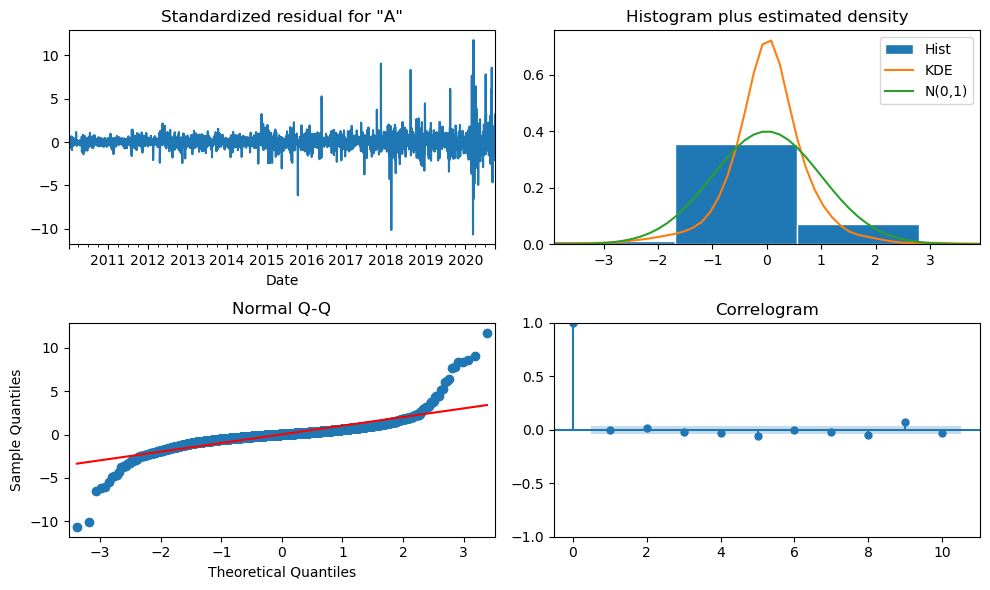

In [58]:
# Obtain diagnostic plots
fig = ar_3_ma_3_model.plot_diagnostics()
fig.set_size_inches(10,6)
fig.tight_layout()


In [59]:
# Obtain summary of model
ar_3_ma_3_model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:              Adj Close   No. Observations:                 2805
Model:                 ARIMA(3, 2, 3)   Log Likelihood               -3871.342
Date:                Thu, 02 Nov 2023   AIC                           7756.684
Time:                        01:00:13   BIC                           7798.254
Sample:                    01-01-2010   HQIC                          7771.688
                         - 10-01-2020                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -2.0553      0.008   -244.888      0.000      -2.072      -2.039
ar.L2         -1.2218      0.014    -88.654      0.000      -1.249      -1.195
ar.L3         -0.1287      0.007    -18.375      0.000      -0.142      -0.115
ma.L1          0.9455      0.054     17.543      0.000       0.840       1.051
ma.L2         -0.9610      0.106     -9.065      0.000      -1.169      -0.753
ma.L3         -0.9844      0.054    -18.093      0.000      -1.091      -0.878
sigma2         0.9250      0.049     18.725      0.000       0.828       1.022
===================================================================================
Ljung-Box (L1) (Q):                   0.01   Jarque-Bera (JB):            106961.78
Prob(Q):                              0.92   Prob(JB):                         0.00
Heteroskedasticity (H):              10.25   Skew:                             0.90
Prob(H) (two-sided):                  0.00   Kurtosis:                        33.21
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

------------------------------------------------------------
Regression Metrics: 
------------------------------------------------------------
- MAE = 2.980
- MSE = 15.615
- RMSE = 3.952
- R^2 = -0.214
- MAPE = 2.05%


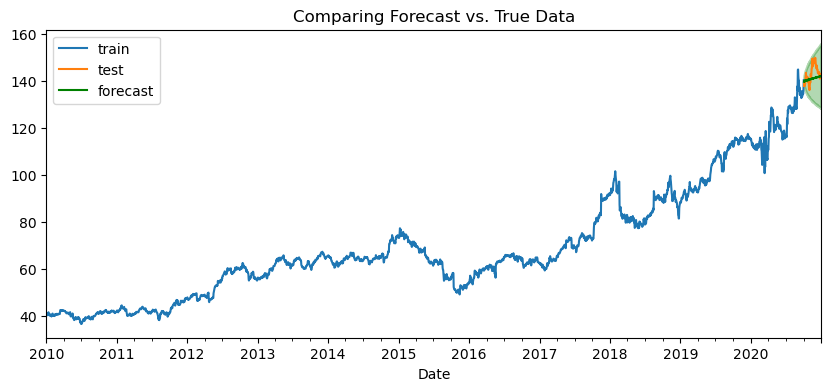

In [60]:
# Obtain summary of forecast as dataframe
forecast_df = ar_3_ma_3_model.get_forecast(len(test)).summary_frame()
# Plot the forecast with true values
plot_forecast(train, test, forecast_df)
# Obtain metrics
regression_metrics_ts(test, forecast_df['mean'])



In [61]:
# Build the model with the best AIC
p = 2  # AR component 

d = 1  # Number of differencing required to make stationary

q =  3 # MA component 

# Define and fit the model
ar_2_ma_3_model = tsa.ARIMA(train, order=(p,d,q)).fit()

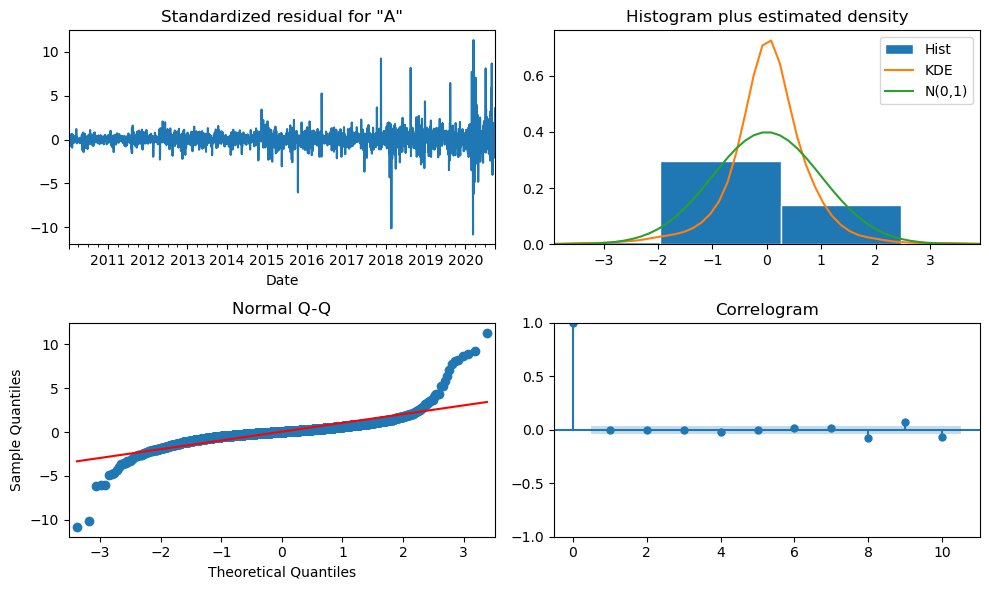

In [62]:
# Obtain diagnostic plots
fig = ar_2_ma_3_model.plot_diagnostics()
fig.set_size_inches(10,6)
fig.tight_layout()

In [63]:
# Obtain summary of model
ar_2_ma_3_model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:              Adj Close   No. Observations:                 2805
Model:                 ARIMA(2, 1, 3)   Log Likelihood               -3879.482
Date:                Thu, 02 Nov 2023   AIC                           7770.963
Time:                        01:01:25   BIC                           7806.596
Sample:                    01-01-2010   HQIC                          7783.824
                         - 10-01-2020                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          1.5164      0.042     35.773      0.000       1.433       1.599
ar.L2         -0.8590      0.042    -20.612      0.000      -0.941      -0.777
ma.L1         -1.6398      0.044    -37.331      0.000      -1.726      -1.554
ma.L2          1.0650      0.045     23.443      0.000       0.976       1.154
ma.L3         -0.1412      0.007    -19.934      0.000      -0.155      -0.127
sigma2         0.9316      0.007    133.671      0.000       0.918       0.945
===================================================================================
Ljung-Box (L1) (Q):                   0.01   Jarque-Bera (JB):            106870.37
Prob(Q):                              0.91   Prob(JB):                         0.00
Heteroskedasticity (H):              10.32   Skew:                             0.96
Prob(H) (two-sided):                  0.00   Kurtosis:                        33.18
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

------------------------------------------------------------
Regression Metrics: 
------------------------------------------------------------
- MAE = 4.145
- MSE = 26.206
- RMSE = 5.119
- R^2 = -1.038
- MAPE = 2.85%


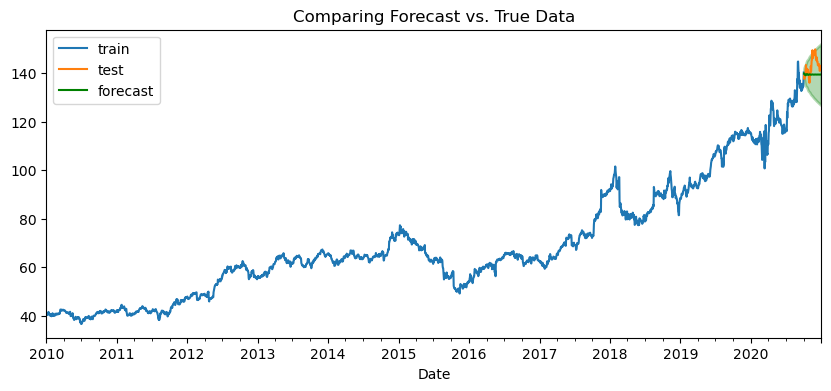

In [64]:
# Obtain summary of forecast as dataframe
forecast_df = ar_2_ma_3_model.get_forecast(len(test)).summary_frame()
# Plot the forecast with true values
plot_forecast(train, test, forecast_df)
# Obtain metrics
regression_metrics_ts(test, forecast_df['mean'])

In [65]:
# Build the model with the best AIC
p = 3  # AR component 

d = 3  # Number of differencing required to make stationary

q =  3 # MA component 

# Define and fit the model
ar_3_d3_ma_3_model = tsa.ARIMA(train, order=(p,d,q)).fit()

C:\Users\Owner\Anaconda3\envs\dojo-env\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'
C:\Users\Owner\Anaconda3\envs\dojo-env\lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


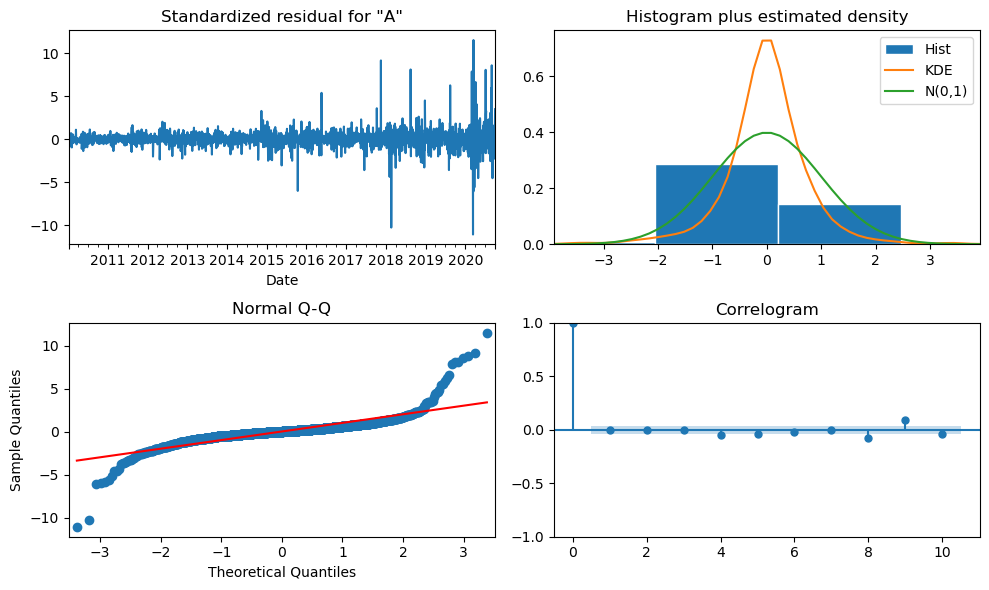

In [66]:
# Obtain diagnostic plots
fig = ar_3_d3_ma_3_model.plot_diagnostics()
fig.set_size_inches(10,6)
fig.tight_layout()

In [67]:
# Obtain summary of model
ar_3_d3_ma_3_model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:              Adj Close   No. Observations:                 2805
Model:                 ARIMA(3, 3, 3)   Log Likelihood               -3898.111
Date:                Thu, 02 Nov 2023   AIC                           7810.222
Time:                        01:07:32   BIC                           7851.789
Sample:                    01-01-2010   HQIC                          7825.226
                         - 10-01-2020                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -1.1200      0.015    -76.144      0.000      -1.149      -1.091
ar.L2         -0.1137      0.011    -10.421      0.000      -0.135      -0.092
ar.L3          0.0068      0.007      1.016      0.310      -0.006       0.020
ma.L1         -0.9986      1.889     -0.529      0.597      -4.701       2.704
ma.L2         -1.0000      3.778     -0.265      0.791      -8.404       6.404
ma.L3          0.9986      1.889      0.529      0.597      -2.704       4.701
sigma2         0.9369      1.758      0.533      0.594      -2.509       4.382
===================================================================================
Ljung-Box (L1) (Q):                   0.00   Jarque-Bera (JB):            112888.05
Prob(Q):                              0.96   Prob(JB):                         0.00
Heteroskedasticity (H):              10.50   Skew:                             0.90
Prob(H) (two-sided):                  0.00   Kurtosis:                        34.04
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

------------------------------------------------------------
Regression Metrics: 
------------------------------------------------------------
- MAE = 2.647
- MSE = 10.206
- RMSE = 3.195
- R^2 = 0.206
- MAPE = 1.84%


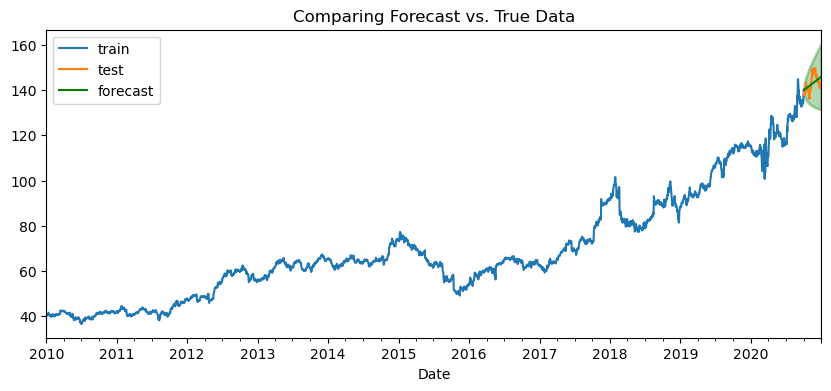

In [68]:
# Obtain summary of forecast as dataframe
forecast_df = ar_3_d3_ma_3_model.get_forecast(len(test)).summary_frame()
# Plot the forecast with true values
plot_forecast(train, test, forecast_df)
# Obtain metrics
regression_metrics_ts(test, forecast_df['mean'])

# Explanation

How good was your model, according to your Mean Absolute Percentage Error? I would use the 3,2,3 model. Diferencing twice instead of once made a large reduction in the MAPE score, going from 2.85% with the 2,1,3 model to 2.05% in the 3-2-3 model. 

The 3,3,3 model performed well in terms of MAPE score at 1.84% but I am not sure I would use as the P>|z| or p-values were much higher than the other models showing lower significance.

How good was your model in terms of how well the forecast seems to follow the test data, visually?  (Hint: You may want to plot fewer training data lags to see this. The 3,2,3 and 3,3,3 models both followed the forecast quite well with the 3,3,3 model staying more squarely in the green forecast area than the 3,2,3 model. )